# PREDICTING TRACK SUCCESS ON SPOTIFY USING COVER ART
 - Capstone Project
 - Student- Sabina Bains
 - Presentation Date- 10/07/2022
 - Instructor- Abhineet Kulkarni

## BUSINESS UNDERSTANDING

Album art has played an important role in music. It gives visual representation and additional context to the story behind an album. Perhaps most importantly, it helped artists sell music. Before streaming was introducted into the world of music, albums were largely judged by their artwork. Iconic albums such as "Abbey Road" by The Beatles and "Nevermind" by Nirvana have artwork that are still frequently talked about today.

However, in recent years streaming services such as Spotify have dominated, with streaming making up 80% of revenue in the U.S. music industry. Artists and labels have been left wondering if this shift from hard copies to streaming has affected the prominence of albums, and therefore album artwork. The Playist Effect is a phenomenon that suggests with the rise of streaming, subscribers largest listen to curated auto-play playlists with individual tracks rather an albums as a whole.

with Spotify leading the music streaming industry, it's crucial for record labels to understand the effectiveness of albums and their artwork in this space.

This analysis will look at the popularity of tracks from Spotify's discovery playlists and their respective artwork to determine which album styles are associated with track success.

## DATA UNDERSTANDING

In [1]:
!pip3 install spotipy --upgrade
!pip3 install pillow
!pip3 install ipynb

#### Importing Packages

In [2]:
from sklearn.model_selection import train_test_split
from matplotlib import image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import tensorflow.keras.backend as K

# changing colors of output
import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = 'grey'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# importing color coding functions from another file
%run "helper_functions.ipynb"

#### Importing Target Variables

In [3]:
# importing dataset created from API pulls in other jupyter notebook. 
df_full = pd.read_csv('data/popularity_index.csv')

#### Descriptive Statistics for Target Variable

        popularity
count  1860.000000
mean     30.078495
std      11.852113
min       0.000000
25%      22.000000
50%      29.000000
75%      37.000000
max      81.000000


Data is slightly skewed to the right with a mean of 30, which makes sense because this playlist is for up and coming artists / labels, outliers would be more popular music


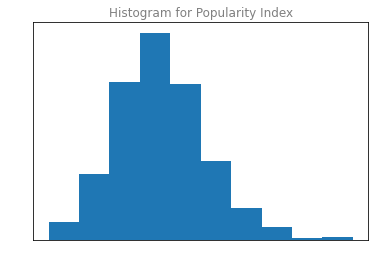

In [85]:
# Looking at descriptive statistics for target variable Popularity Index. 
print(df_full[['key','popularity']].describe())

# Plotting Histogram of data
df_full.hist('popularity')
plt.title('Histogram for Popularity Index')
plt.grid(False)

print('\n\nData is slightly skewed to the right with a mean of 30, which makes sense because this playlist is for up and coming artists / labels, outliers would be more popular music.')

#### Preview of Album Artwork

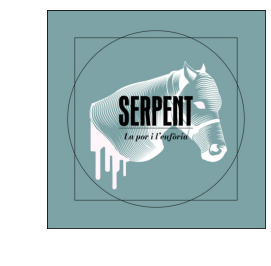

In [5]:
# Displaying example of photos downloaded from Spotify API
album_art_example = mpimg.imread(os.getcwd()+"/data/album_art/"+os.listdir('data/album_art_resized')[9])

plt.imshow(album_art_example)
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
plt.show()

In [6]:
# importing saved album art files as values in dictionary, with key being the track name. This is so we can later tie the target variable to the features (album art)

# initializing dict
image_dict = {}

# looping through each album art saved
for file in os.listdir("data/album_art_resized/"):
    
    filename = file.split('.jpg')[0]
    
    # assigning track name as key, and value as matrix form of album art (Height, Width, Depth)
    try:
        image_dict[filename] = (mpimg.imread('data/album_art_resized/'+file))
        
        # Not including image if it is not in uniform shape
        if image_dict[filename].shape == (60,60):
                image_dict[filename] = np.stack((image_dict[filename],)*3, axis=-1)
                
                newshape = image_dict[filename].shape
                print(file+' was resized to '+str(newshape)) 
            
        if image_dict[filename].shape != (60,60,3):
            del image_dict[filename]
            
    # created error list to observe files that were not read in properly        
    except:
        print(file+' did not import')

Baby Choppa_2021.jpg was resized to (60, 60, 3)
Say Datt_Hip-Hop.jpg was resized to (60, 60, 3)
.DS_Store did not import
Spirito della Domenica_Italia.jpg was resized to (60, 60, 3)
Consolation Prize_Rock.jpg was resized to (60, 60, 3)
Something_NZ.jpg was resized to (60, 60, 3)
PDF_All Genres.jpg was resized to (60, 60, 3)
HEAVY METAL_2021.jpg was resized to (60, 60, 3)
Rave_All Genres.jpg was resized to (60, 60, 3)
Family Man_Rock.jpg was resized to (60, 60, 3)
concussion_2021.jpg was resized to (60, 60, 3)
Lost_NZ.jpg was resized to (60, 60, 3)
Goner feat Kellin Quinn_Rock.jpg was resized to (60, 60, 3)
White Picket Fence_2021.jpg was resized to (60, 60, 3)
At Least_Folk.jpg was resized to (60, 60, 3)
Portals_R&B.jpg was resized to (60, 60, 3)
Inconsciencia_Latin.jpg was resized to (60, 60, 3)
Rave_Dance.jpg was resized to (60, 60, 3)
BE FREE_R&B.jpg was resized to (60, 60, 3)
Be Your Lover_NZ.jpg was resized to (60, 60, 3)
Grimiest Ever_Dance.jpg was resized to (60, 60, 3)
WORK 4 A

In [7]:
# filtering down dataframe so that only the files that were read in properly are included. 
df = df_full.loc[df_full.key.isin(image_dict.keys())]

In [8]:
del_list = []

for key in image_dict.keys():
    if key in df.key.to_list():
        pass
    else:
        print("Could not find associated value for "+key+", delete from the album art dictionary")
        del_list.append(key)
        
for key in del_list:
    del image_dict[key]

Could not find associated value for 4 Ya Kiss_Experimental, delete from the album art dictionary
Could not find associated value for .SYSTVMRVSTVRT, delete from the album art dictionary
Could not find associated value for .SYSTVMRVSTVRT*, delete from the album art dictionary


In [9]:
# Sorting Dictionary to match DataFrame order
image_dict = collections.OrderedDict(sorted(image_dict.items()))

In [10]:
# Checking if order of names matches, so we can accuractly match features with target data. 

if df.key.to_list() == list(image_dict.keys()):
    print('data aligns, ready to process')
else:
    print('data does not align')

data aligns, ready to process


### Preliminary analysis of album artwork colors and relation to popularity index

In [11]:
top_colors_dict = {}

for k, v in image_dict.items():
    try:
        top_colors_dict[k] = get_top_colors(image_dict[k])
    except:
        print(k, image_dict[k].shape)

18 feat Paloalto_Korea (60, 60, 3)


In [13]:
top_labels_dict = {}

for k, v in top_colors_dict.items():
    top_labels_dict[k] = []
    for color in top_colors_dict[k]:
         top_labels_dict[k].append(classify(color))

In [14]:
del_list = []

for k, v in top_labels_dict.items():
    if len(v) != 3:
        del_list.append(k)
        
for key in del_list:
    del top_labels_dict[key]
    print(key+' was deleted')

Escapar_España was deleted
Exit Music_GSA was deleted


In [15]:
colors = pd.DataFrame(top_labels_dict.items(), columns=['key','color'])

In [16]:
# adding column to distinguish black and white images from regular ones
colors['b_w'] = colors.color.apply(b_w)

In [17]:
colors = pd.merge(colors, df[['key','popularity']], on='key', how = 'inner')
colors[['color 1','color 2','color 3']] = colors.color.apply(pd.Series)

No major difference in mean between dominant color in album artwork


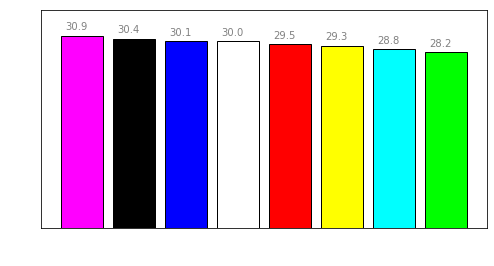

In [51]:
colors_grouped = pd.DataFrame(colors.groupby('color 1')['popularity'].mean()).reset_index().sort_values(by = 'popularity', ascending = False)

plt.figure(figsize=(8,4))
bars = plt.bar(colors_grouped['color 1'], colors_grouped['popularity'], color=colors_grouped['color 1'], edgecolor = "black", width=0.8)

plt.ylim([0, 35])

plt.ylabel('Average Popularity Index')
plt.xlabel('Dominant Color in Album Artwork')



for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + .08, yval + 1, "{:.1f}".format(yval))
    
print('No major difference in mean between dominant color in album artwork')

No major difference in mean between color artwork and black and white artwork


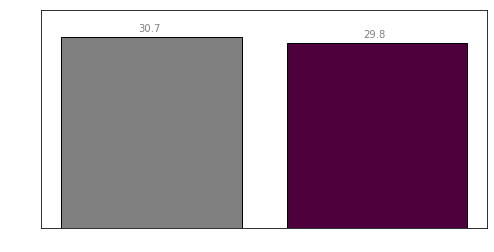

In [19]:
b_w_grouped = pd.DataFrame(colors.groupby('b_w')['popularity'].mean()).reset_index().sort_values(by = 'popularity', ascending = False)

plt.figure(figsize=(8,4))
bars = plt.bar(b_w_grouped['b_w'], b_w_grouped['popularity'], edgecolor = "black", color = ['grey' , '#4D003C'])


plt.ylim([0, 35])
plt.ylabel('Average Popularity Index')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + .34, yval + 1, "{:.1f}".format(yval))
    
print('No major difference in mean between color artwork and black and white artwork')

## DATA PREPARATION

In [20]:
# Creating feature array from album artwork dictionary
X = np.array(list(image_dict.values()))

# Assuring shape is correct
X.shape

(1859, 60, 60, 3)

In [21]:
# Creating target array from df with popularity index
y = np.array(df.popularity).reshape(len(df.popularity), 1)

# Assuring shape is correct
y.shape

(1859, 1)

In [22]:
# Split the data into Train and Test, so we can later validate our model on "unseen" data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [23]:
# dividing Training and testing data by 255 to normalize
X_train = X_train / 255
X_test  = X_test  / 255

## MODELING

#### Creating functions to evaluate models more efficiently

In [55]:
# creating function to plot history MSE of CNN Model 
def plot_history(model, history, X_test, y_test):
    
    plt.plot(history.history['mse'], label='mse')
    plt.plot(history.history['val_mse'], label = 'val_mse')
    
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend(loc='upper right')
    
    loss, mse, R2 = model.evaluate(X_test,  y_test)
    return np.sqrt(mse), R2

In [25]:
# creating function to produce scatter plot of predicted values and true values
def plot_scatter(model, X_test):
    
    y_hat = model.predict(X_test);
    
    error = y_test - y_hat
    rmse = np.sqrt(np.mean(error**2))

    plt.figure(figsize=(5, 5))
    plt.scatter(y_hat,y_test)
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    yvy = np.linspace(0,80,2)
    plt.plot(yvy, yvy, color='red', linestyle='dashed')
    plt.xlim([0, 80])
    plt.ylim([0, 80])

In [26]:
# function to calculate R2 score to assess model's ability to predict popularity
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#### Model 2: Reduced Pixels

In [62]:
model_2 = Sequential()
model_2.add(layers.Conv2D(64, kernel_size=(3,3), input_shape = X_train[0].shape))
model_2.add(Flatten())
model_2.add(layers.Dense(1, activation='linear'))

model_2.compile(optimizer='adam',
              loss='mse',
              metrics=['mse', r2_score])

history_2 = model_2.fit(X_train, y_train, epochs=5, 
                    validation_data=(X_test, y_test))

Epoch 1/5
44/44 [==============================] - 2s 36ms/step - loss: 337.8067 - mse: 337.8067 - r2_score: -1.6032 - val_loss: 248.7482 - val_mse: 248.7482 - val_r2_score: -0.8274
Epoch 2/5
44/44 [==============================] - 1s 32ms/step - loss: 178.4038 - mse: 178.4038 - r2_score: -0.3620 - val_loss: 148.7067 - val_mse: 148.7067 - val_r2_score: -0.0544
Epoch 3/5
44/44 [==============================] - 1s 34ms/step - loss: 144.4942 - mse: 144.4942 - r2_score: -0.0777 - val_loss: 142.7396 - val_mse: 142.7396 - val_r2_score: -0.0115
Epoch 4/5
44/44 [==============================] - 1s 32ms/step - loss: 133.7703 - mse: 133.7703 - r2_score: -0.0028 - val_loss: 203.2883 - val_mse: 203.2883 - val_r2_score: -0.4536
Epoch 5/5
44/44 [==============================] - 1s 34ms/step - loss: 130.2084 - mse: 130.2084 - r2_score: 0.0321 - val_loss: 188.5957 - val_mse: 188.5957 - val_r2_score: -0.3985


15/15 [==============================] - 0s 11ms/step - loss: 188.5957 - mse: 188.5957 - r2_score: -0.3985


Our second model after reducing pixels outperforms our baseline model with the larger dimensions, 
with a significantly faster computiation time. and a RMSE of 13.7. This will allow us to increase epochs and add layers. 


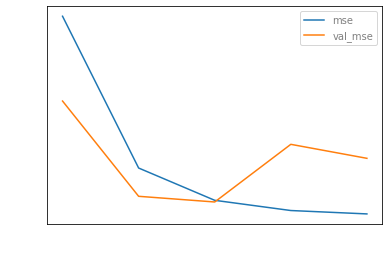

In [63]:
rmse_2, r2_2 = plot_history(model_2, history_2, X_test, y_test)

print('''\n\nOur second model after reducing pixels outperforms our baseline model with the larger dimensions, 
with a significantly faster computiation time. and a RMSE of {:.1f}. This will allow us to increase epochs and add layers. '''.format(rmse_2))

#### Model #3: increased layers and epochs

In [64]:
# as it's good to use a repeating structure for cnns, lets add some more layers and increase epochs now that our model is more simplified
model_3 = Sequential()
model_3.add(layers.Conv2D(64, kernel_size =(3, 3), input_shape = X_train[0].shape))
model_3.add(layers.MaxPooling2D(pool_size =(2, 2)))
model_3.add(layers.Conv2D(64, (3, 3)))
model_3.add(layers.MaxPooling2D(pool_size =(2, 2)))
model_3.add(Flatten())
model_3.add(layers.Dense(1, activation='linear'))
   
    
# training
model_3.compile(optimizer='adam',
              loss='mse',
              metrics=['mse', r2_score])
  
# fitting
history_3 = model_3.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_test, y_test))

Epoch 1/15
44/44 [==============================] - 4s 102ms/step - loss: 329.5891 - mse: 329.5891 - r2_score: -1.6161 - val_loss: 267.1311 - val_mse: 267.1311 - val_r2_score: -0.9249
Epoch 2/15
44/44 [==============================] - 5s 107ms/step - loss: 192.0276 - mse: 192.0276 - r2_score: -0.4552 - val_loss: 157.0188 - val_mse: 157.0188 - val_r2_score: -0.1214
Epoch 3/15
44/44 [==============================] - 4s 98ms/step - loss: 152.0502 - mse: 152.0502 - r2_score: -0.1358 - val_loss: 159.1019 - val_mse: 159.1019 - val_r2_score: -0.1495
Epoch 4/15
44/44 [==============================] - 5s 104ms/step - loss: 156.2243 - mse: 156.2243 - r2_score: -0.2010 - val_loss: 151.4918 - val_mse: 151.4918 - val_r2_score: -0.0700
Epoch 5/15
44/44 [==============================] - 5s 103ms/step - loss: 165.4673 - mse: 165.4673 - r2_score: -0.2680 - val_loss: 153.3160 - val_mse: 153.3160 - val_r2_score: -0.0820
Epoch 6/15
44/44 [==============================] - 5s 103ms/step - loss: 143.277

15/15 [==============================] - 0s 26ms/step - loss: 146.6708 - mse: 146.6708 - r2_score: -0.0324


The third model iteration just barely outperforms our previous model with an RMSE of 12.1, testing data doesn't show any signs of overfitting,
so we will continue to add layers / increase epochs


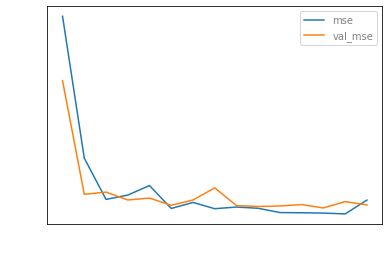

In [65]:
rmse_3, r2_3 = plot_history(model_3, history_3, X_test, y_test)

print('''\n\nThe third model iteration just barely outperforms our previous model with an RMSE of {:.1f}, testing data doesn't show any signs of overfitting,
so we will continue to add layers / increase epochs'''.format(rmse_3))

#### Model 4. further increase in layers and epochs

In [66]:
# adding yet another Conv and Pooling layer.
model_4 = Sequential()
model_4.add(layers.Conv2D(64, kernel_size=(3,3), input_shape = X_train[0].shape))
model_4.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(Flatten())
model_4.add(layers.Dense(1, activation='linear'))

model_4.compile(optimizer='adam',
              loss='mse',
              metrics=['mse', r2_score])

# fitting the model
history_4 = model_4.fit(X_train, y_train, epochs=25, 
                    validation_data=(X_test, y_test))

Epoch 1/25
44/44 [==============================] - 5s 115ms/step - loss: 351.5802 - mse: 351.5802 - r2_score: -1.7268 - val_loss: 248.1107 - val_mse: 248.1107 - val_r2_score: -0.8470
Epoch 2/25
44/44 [==============================] - 5s 111ms/step - loss: 193.7157 - mse: 193.7157 - r2_score: -0.4662 - val_loss: 172.5824 - val_mse: 172.5824 - val_r2_score: -0.2411
Epoch 3/25
44/44 [==============================] - 5s 110ms/step - loss: 158.5639 - mse: 158.5639 - r2_score: -0.1868 - val_loss: 164.5834 - val_mse: 164.5834 - val_r2_score: -0.1632
Epoch 4/25
44/44 [==============================] - 5s 110ms/step - loss: 155.3373 - mse: 155.3373 - r2_score: -0.1693 - val_loss: 155.2682 - val_mse: 155.2682 - val_r2_score: -0.1132
Epoch 5/25
44/44 [==============================] - 5s 110ms/step - loss: 149.0797 - mse: 149.0797 - r2_score: -0.1205 - val_loss: 150.7857 - val_mse: 150.7857 - val_r2_score: -0.0645
Epoch 6/25
44/44 [==============================] - 5s 111ms/step - loss: 149.51

15/15 [==============================] - 0s 30ms/step - loss: 149.1422 - mse: 149.1422 - r2_score: -0.0474


The fourth model does slightly worse than model 3, with an RMSE of 12.2. Looking at the below scatterplot this model
doesnt seem to have any predictive power. We will begin to tune hyperparameters, but will need to look at an R Squared value to determine if this model 
is useful. Although the validation MSE does not show any signs of overfitting, MSE seems to be plateauing, so adding layer's doesn't seem as if it would help. 


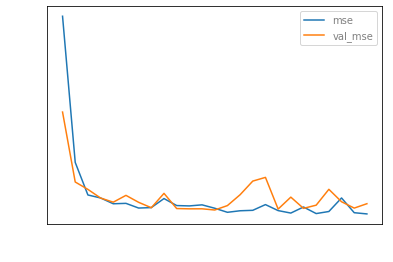

In [86]:
rmse_4, r2_4 = plot_history(model_4, history_4, X_test, y_test)

print('''\n\nThe fourth model does slightly worse than model 3, with an RMSE of {:.1f}. Looking at the below scatterplot this model
doesnt seem to have any predictive power. We will begin to tune hyperparameters, but will need to look at an R Squared value to determine if this model 
is useful. Although the validation MSE does not show any signs of overfitting, MSE seems to be plateauing, so adding layer's doesn't seem as if it would help. '''.format(rmse_4))

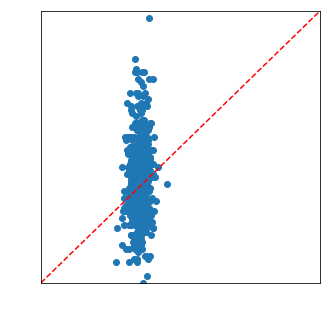

In [68]:
# scatterplot shows model is not predicting well
plot_scatter(model_4, X_test)

#### Model 5: tuning hyperparameters with function

In [69]:
# building a function to test hyperparameters
def build_cnn(X_train, y_train, X_test, y_test, neurons, kernel_size, activation, epochs, pool_size, padding):
    
    # building the model
    model = Sequential()
    model.add(layers.Conv2D(neurons, kernel_size=kernel_size, activation= activation))
    model.add(layers.MaxPooling2D(pool_size = pool_size))
    model.add(layers.Conv2D(neurons, kernel_size=kernel_size, activation = activation, padding=padding))
    model.add(layers.MaxPooling2D(pool_size = pool_size))
    model.add(Flatten())
    model.add(layers.Dense(1, activation=activation))

    # training
    model.compile(optimizer='adam', loss='mse', metrics=['mse', r2_score])
    
    # fitting
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

    return model, history

In [52]:
model_5, history_5 = build_cnn(X_train, y_train, X_test, y_test, 64, (5,5), 'relu', 20, (2,2), 'valid')

Epoch 1/20
44/44 [==============================] - 12s 262ms/step - loss: 301.3087 - mse: 301.3087 - r2_score: -1.3857 - val_loss: 200.3323 - val_mse: 200.3323 - val_r2_score: -0.4622
Epoch 2/20
44/44 [==============================] - 11s 261ms/step - loss: 168.6030 - mse: 168.6030 - r2_score: -0.2660 - val_loss: 161.3708 - val_mse: 161.3708 - val_r2_score: -0.1505
Epoch 3/20
44/44 [==============================] - 11s 257ms/step - loss: 160.8419 - mse: 160.8419 - r2_score: -0.2240 - val_loss: 159.6965 - val_mse: 159.6965 - val_r2_score: -0.1157
Epoch 4/20
44/44 [==============================] - 12s 267ms/step - loss: 159.2412 - mse: 159.2412 - r2_score: -0.1885 - val_loss: 157.3279 - val_mse: 157.3279 - val_r2_score: -0.1108
Epoch 5/20
44/44 [==============================] - 12s 264ms/step - loss: 153.0467 - mse: 153.0467 - r2_score: -0.1397 - val_loss: 150.8196 - val_mse: 150.8196 - val_r2_score: -0.0638
Epoch 6/20
44/44 [==============================] - 11s 257ms/step - loss: 

15/15 [==============================] - 1s 50ms/step - loss: 144.8513 - mse: 144.8513 - r2_score: -0.0294


The fifth model has an RMSE of 12.0, which outperforms the others, however it generates an R Squared of -0.0


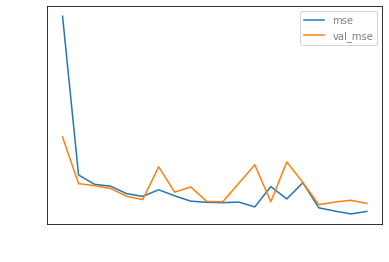

In [87]:
rmse_5, R2_5 = plot_history(model_5, history_5, X_test, y_test)

print('''\n\nThe fifth model has an RMSE of {:.1f}, which outperforms the others, however it generates an R Squared of {:.1f}'''.format(rmse_5, R2_5))

## FINAL MODEL EVALUATION

In [79]:
# loop to look at all model results side by side
for idx, i in enumerate([rmse_2, rmse_3, rmse_4, rmse_5]):
    print('model '+str(idx+2)+" RMSE: "+str(i))

model 2 RMSE: 13.733013966621526
model 3 RMSE: 12.110773608747863
model 4 RMSE: 12.212377579230644
model 5 RMSE: 12.035418058455505



After using the create_cnn function to test hyperparameters to further fine tune, The final model chosen was model 5, with a filter size of 5 x 5, a pooling size of 2 x 2,
linear activation, and no padding. This model was chosen because it generated the lowest Root Mean Squared Error value of 12.0. This means X. Although this model outperformed the
others, it is not an effective predictor for Spotify's popularity index. The scatterplot of
true vs. predicted values demonstrate this, as well as it's R Squared score of -0.0. This essentially tells us the model is about as efficient at predicting popularity than a simple
averaging of popularity, 30.7, would be able to predict, which is evident from the scatter plot.  



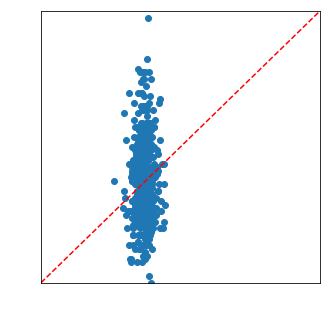

In [84]:
print('''
After using the create_cnn function to test hyperparameters to further fine tune, The final model chosen was model 5, with a filter size of 5 x 5, a pooling size of 2 x 2,
linear activation, and no padding. This model was chosen because it generated the lowest Root Mean Squared Error value of {:.1f}. Although this model outperformed the
others, it is not an effective predictor for Spotify's popularity index. The scatterplot of
true vs. predicted values demonstrate this, as well as it's R Squared score of {:.1f}. This essentially tells us the model is about as efficient at predicting popularity than a simple
averaging of popularity, {:.1f}, would be able to predict, which is evident from the scatter plot.  
'''.format(rmse_5, R2_5, y_test.mean()))

plot_scatter(model_3, X_test)

## CONCLUSION

- Our final model was unsucessful in predicting Spotify popularity by album artwork. 


- I would also look into finding a different target variable to measure "success". 